In [1]:
from preprocess_image import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 浏览项目文件结构

已下载了项目内容，观察该项目有3个压缩包:
imgs.zip: 包含了训练集与测试集图像，训练集内有10种驾驶状态的图像，其目录树如下:

.<br>
|test<br>
|train<br>
|--|c0<br>
|--|c1<br>
|--|c2<br>
|--|c3<br>
|--|c4<br>
|--|c5<br>
|--|c6<br>
|--|c7<br>
|--|c8<br>
|--|c9<br>

driver_imgs_list.csv.zip: 含有一份关于所有训练集图像的司机ID与驾驶状态类别的清单文件，可以从中挖掘出总的图像数量，各个驾驶状态类别的图像数量等等信息

sample_submission.csv.zip: 含有一份关于测试集图像的清单文件，用于填入每一张图像相对于10种驾驶状态的被识别的概率，即提交结果用。

# 读取driver_imgs_list.csv

In [2]:
try:
    img_drivers_df = pd.read_csv("../driver_imgs_list.csv")
    print("Load dataset:{} {}".format(*img_drivers_df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Load dataset:22424 3


In [3]:
img_drivers_df.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_81162.jpg
freq,1237,2489,1


In [4]:
img_drivers_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# 统计训练集中10种驾驶状态的图像数量

In [5]:
class_df = pd.DataFrame(index=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], columns=['Classname Count'])
class_df = class_df.fillna(0)

for index, row in img_drivers_df.iterrows():
    class_df.loc[row["classname"]] += 1

In [6]:
class_df.describe()

,Classname Count
count,10.000000
mean,2242.400000
std,175.387951
min,1911.000000
25%,2163.500000
50%,2314.500000
75%,2325.750000
max,2489.000000


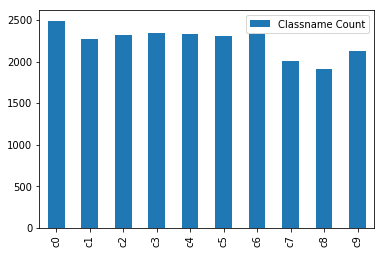

In [7]:
ax = class_df.plot(kind='bar')
plt.savefig("classname_count.png")
plt.show()
plt.close()

# 统计训练集中各个司机分别对于10种驾驶状态的图像数量

In [8]:
subject_dict = {}
subject_temp = ""
classname_temp = ""
driver_count = 0
driver_classname_count = 0
drivers_count = 0


def add_driver_subject_information(dict, subject, classname, count):
    if subject in dict:
        dict[subject].append(count)
    else:
        dict[subject] = [count]

for index, row in img_drivers_df.iterrows():
    if subject_temp is not row["subject"]:
        if driver_classname_count > 1:
            add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)
            driver_classname_count = 0

        subject_temp = row["subject"]
        driver_count = 1
        drivers_count += 1
    else:
        driver_count += 1
        if classname_temp is not row["classname"]:
            if driver_classname_count != 0:
                driver_classname_count += 1
                add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)
            classname_temp = row["classname"]
            driver_classname_count = 1
        else:
            driver_classname_count += 1
            
add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)

In [9]:
subject_df = pd.DataFrame(index=subject_dict.keys(),
                          columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for key in subject_dict.keys():
    subject_df.loc[key] = subject_dict[key]

print(subject_df)

       c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
p002   76   75   87   80   85   77   84   73   45   51
p012   84   96   92   90   98   97   76   73   63   62
p014  100  104  101  101  104  103  102   78   39   52
p015   79   86   89   95  102  102  100   82   87   61
p016  111  103  102  129  105  105  109  102  100  120
p021  135  132  128  129  133  131  127   99  100  131
p022  129  130  129  130  131  131  132   99   99  131
p024  130  130  129  131  130  132  130  102  100  120
p026  130  130  131  132  127  131  129   98   98   98
p035   94   82   89   90   90   90   95   88   57   81
p039   65   64   71   66   63   65   64   65   71   65
p041   60   65   61   61   61   62   62   62   60   59
p042   59   60   61   60   59   60   60   60   60   60
p045   75   76   77   76   76   77   72   68   67   68
p047   80   92   82   87   83   88   82   83   83   83
p049   84   86  120  111  110  117  120   75   80  116
p050  123   46   53   99   84   92   83   82   66   70
p051  182 

# 图像数据预处理

## 1. 挑出训练集异常值

观察训练集各个驾驶状态分类的图像，发现存在有部分图像与该驾驶状态不符，以及难以区分的图像，我采用保留难以区分的图像，只找出与该驾驶状态不符的图像，并调用append_outliers_to_dict函数将异常值收集起来

In [10]:
# 添加C0异常值
outliers = ['100074', '101091', '101392', '101419', '101555', '101668', '10514', '14552', '14757', '16927',
            '18680', '20144', '21155', '2151', '21699', '27453', '27568', '2843', '28578', '29350',
            '31032', '31659', '3349', '34028', '34380', '35327', '35809', '3600', '36287', '36854',
            '37728', '38288', '41079', '4335', '45005', '45571', '47447', '48931', '49150', '51985',
            '53288', '54712', '56120', '56251', '56357', '58013', '58551', '5963', '6002', '60226',
            '62095', '62383', '66097', '68134', '68246', '68266', '68629', '68630', '70795', '71478',
            '71483', '71499', '73825', '79194', '81035', '81735', '86913', '87245', '88085', '89173',
            '89653', '90273', '90865', '91414', '91777', '94842', '94969', '95252', '95596', '96741',
            '99515', '99779', '99846']
append_outliers_to_dict('c0', outliers)

# 添加C1异常值
outliers = []
append_outliers_to_dict('c1', outliers)

# 添加C2异常值
outliers = ['69693', '76349', '86001']
append_outliers_to_dict('c2', outliers)

# 添加C3异常值
outliers = []
append_outliers_to_dict('c3', outliers)

# 添加C4异常值
outliers = ['35657', '38427', '40343', '53828', '63738', '77347', '9170', '92769']
append_outliers_to_dict('c4', outliers)

# 添加C5异常值
outliers = ['101079', '12442', '19127', '27454', '44224', '78504', '87062']
append_outliers_to_dict('c5', outliers)

# 添加C6异常值
outliers = []
append_outliers_to_dict('c6', outliers)

# 添加C7异常值
outliers = ['74115', '7414', '95214']
append_outliers_to_dict('c7', outliers)

# 添加C8异常值
outliers = ['10080', '100814', '11324', '13465', '13480', '13438', '13868', '14072', '14084', '14560',
            '16971', '17480', '18737', '18970', '19323', '19616', '22941', '22971', '2378', '25081',
            '26296', '26736', '27663', '27671', '31158', '31174', '36457', '37314', '41462', '42490',
            '47484', '4853', '53436', '53620', '54379', '55008', '56078', '56122', '73917', '76663',
            '83361', '89614']
append_outliers_to_dict('c8', outliers)

# 添加C9异常值
outliers = ['11675', '10917', '1125', '11528', '11675', '12000', '12001', '12154', '13253', '13396',
            '13762', '13982', '14737', '16428', '17355', '18759', '18819', '18997', '19209', '20002',
            '20688', '20775', '21708', '21897', '24030', '24134', '24554', '25913', '26043', '26484',
            '27342', '28025', '29320', '29556', '29906', '30092', '30172', '30893', '32125', '3318',
            '37262', '38453', '38742', '44953', '51826', '52610', '52861', '59747', '60004', '607',
            '61052', '60822', '60903', '61052', '62766', '66278', '67477', '68251', '69130', '69560',
            '69710', '7091', '71015', '75597', '77889', '78934', '81214', '83528', '83868', '8480',
            '8572', '87154', '89196', '91129', '96805', '97943']
append_outliers_to_dict('c9', outliers)

## 2. 将被修改尺寸的新图像保存到指定路径
因为不同模型需要改的尺寸不一样，保存的路径需要加以区分

### CNN模型

In [11]:
target_model_name = 'cnn/'
resize_image_directory = '../resize/'
origin_image_directory = '../train/'
cnn_train_image_directory = resize_image_directory + target_model_name + 'train/'
cnn_image_shape = (128, 128)
cnn_tensor_shape = [cnn_image_shape[0], cnn_image_shape[1], 3]
class_num = len(np.unique(np.asarray(img_drivers_df)[:,1]))

## 3. 划分训练集与验证集
导出driver id列表并随机排序，按4:1比例划分训练集与验证集，并且从中剔除所收集到的异常值

In [12]:
feature_train, label_train, feature_valid, label_valid = \
        train_valid_split(img_drivers_df, 0.2, cnn_train_image_directory, origin_image_directory, cnn_image_shape)

Drivers size:26 valid_total:5
Loading completed


## 搭建模型

### CNN模型

In [13]:
from cnn_model import *

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
conv2d_ksize = (5, 5)
conv2d_strides = (1, 1)
maxpool_ksize = (2, 2)
maxpool_strides = (2, 2)
epoch = 50
keep_probability = 0.5
batch_size = int(len(feature_train) / 8)

In [48]:
run_cnn(cnn_tensor_shape, 
        np.asarray(feature_train), 
        np.asarray(label_train), 
        np.asarray(feature_valid), 
        np.asarray(label_valid), 
        conv2d_ksize,
        conv2d_strides,
        maxpool_ksize,
        maxpool_strides
        epoch, 
        keep_probability, 
        batch_size, class_num)

KeyboardInterrupt: 

In [37]:
np.asarray(feature_train)

array([[[[ 32,  33,  29],
         [ 27,  31,  25],
         [ 26,  30,  24],
         ...,
         [142, 187, 154],
         [ 74, 115,  78],
         [  0,  22,   0]],

        [[ 23,  24,  20],
         [ 20,  24,  18],
         [ 21,  25,  19],
         ...,
         [152, 200, 171],
         [161, 206, 173],
         [187, 229, 194]],

        [[ 18,  22,  17],
         [ 17,  21,  15],
         [ 20,  24,  18],
         ...,
         [158, 215, 190],
         [168, 222, 193],
         [179, 231, 201]],

        ...,

        [[ 96, 141, 145],
         [ 77, 120, 123],
         [ 74, 115, 117],
         ...,
         [  8,   9,   5],
         [  9,   7,   6],
         [  9,   7,   6]],

        [[ 71, 111, 116],
         [ 79, 120, 123],
         [ 79, 118, 120],
         ...,
         [  9,   8,   4],
         [ 10,   7,   3],
         [ 11,   8,   4]],

        [[ 68, 104, 110],
         [ 65, 102, 106],
         [ 68, 108, 107],
         ...,
         [  8,   7,   3],
        

In [38]:
feature_train

[array([[[ 32,  33,  29],
         [ 27,  31,  25],
         [ 26,  30,  24],
         ...,
         [142, 187, 154],
         [ 74, 115,  78],
         [  0,  22,   0]],
 
        [[ 23,  24,  20],
         [ 20,  24,  18],
         [ 21,  25,  19],
         ...,
         [152, 200, 171],
         [161, 206, 173],
         [187, 229, 194]],
 
        [[ 18,  22,  17],
         [ 17,  21,  15],
         [ 20,  24,  18],
         ...,
         [158, 215, 190],
         [168, 222, 193],
         [179, 231, 201]],
 
        ...,
 
        [[ 96, 141, 145],
         [ 77, 120, 123],
         [ 74, 115, 117],
         ...,
         [  8,   9,   5],
         [  9,   7,   6],
         [  9,   7,   6]],
 
        [[ 71, 111, 116],
         [ 79, 120, 123],
         [ 79, 118, 120],
         ...,
         [  9,   8,   4],
         [ 10,   7,   3],
         [ 11,   8,   4]],
 
        [[ 68, 104, 110],
         [ 65, 102, 106],
         [ 68, 108, 107],
         ...,
         [  8,   7,   3],
  